# Tutorial in Hydrology
## Flow Duration and Event Runoff

This is the second tutorial in Hydrology. The notebook shall motivate the use of computer skripting languages to solve tasks in calculations, data analysis and modelling. It is an optional and voluntary extension of the exercises held at KIT.

To get started with Python yourself, you may use the anaconda package https://www.continuum.io/downloads. A Quickstart tutorial for installing and starting is given here: http://conda.pydata.org/docs/get-started.html

(cc) jackisch@kit.edu

In [1]:
#load required packages
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as st
import scipy.optimize as so
%pylab inline

#these can be used to get nicer graphics
#import seaborn as sns
#sns.set(style='whitegrid', palette='deep')
#matplotlib.rcParams['svg.fonttype'] = 'none'

Populating the interactive namespace from numpy and matplotlib


## Flow Duration Curve

The flow duration curve (FDC) is a cumulative density function or plot of the probability (in % of record time) that flow in a stream is likely to equal or exceed some specified value of interest. Possible applications are the assessment of flood protection measures or the design of power plant cooling structures which require some minimum flow.


FDCs are a straight-forward rank-based analysis of measured discharge. To construct them, stream flow discharges are ranked in decreasing order and associated with a given relative plotting position. The plotting position is normalised by the number of data points: If n is the number of flow data points, the highest flow is associated with 1/(n+1) and the lowest flow with n/(n+1).

Through this the exceeding probability of the lowest flow is 100% and decreasing for any other reference level.

In [2]:
#read data
QA = pd.read_csv('QA_m3s.csv') #15 min data of Attert gauges in m3s-1
#define time stamp as index
QA.index=pd.to_datetime(QA.iloc[:,0].values)
#drop old time stamp column
QA=QA.drop('Unnamed: 0',axis=1)

print('These are measured discharges in m3s-1:')
QA.head(5)

These are measured discharges in m3s-1:


,Colpach,Weierbach,Huewelerbach,Useldange
2010-11-01 00:00:00,0.044,0.0005,0.014049,1.189
2010-11-01 00:15:00,0.045,0.0004,0.014049,1.189
2010-11-01 00:30:00,0.045,0.0004,0.014049,1.189
2010-11-01 00:45:00,0.045,0.0004,0.014049,1.189
2010-11-01 01:00:00,0.044,0.0004,0.014049,1.189


We will now accumulate the data to daily means and construct the flow duration curves step by step for the gauge Useldange:

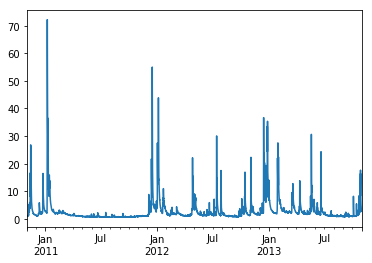

In [3]:
#Useldange example
QA_dummy = QA.Useldange.resample('H').mean() #take hourly means
QA_dummy.plot()

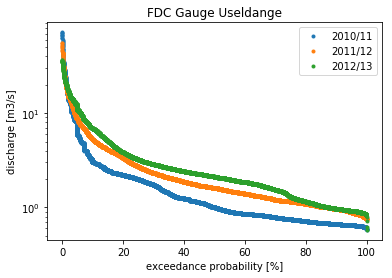

In [4]:
#cut the record into 3 separate years and sort the values:
sortQ1 = QA_dummy.loc[pd.to_datetime('2010-11-01'):pd.to_datetime('2011-10-31')].sort_values().copy()
sortQ2 = QA_dummy.loc[pd.to_datetime('2011-11-01'):pd.to_datetime('2012-10-31')].sort_values().copy()
sortQ3 = QA_dummy.loc[pd.to_datetime('2012-11-01'):pd.to_datetime('2013-10-31')].sort_values().copy()

#calculate the ranks (the [::-1] is just reversing the order):
ranks1 = st.rankdata(sortQ1.values, method='average')[::-1]
ranks2 = st.rankdata(sortQ2.values, method='average')[::-1]
ranks3 = st.rankdata(sortQ3.values, method='average')[::-1]

#normalise the ranks:
prob1 = [100*(ranks1[i]/(len(sortQ1)+1)) for i in range(len(sortQ1)) ]
prob2 = [100*(ranks2[i]/(len(sortQ2)+1)) for i in range(len(sortQ2)) ]
prob3 = [100*(ranks3[i]/(len(sortQ3)+1)) for i in range(len(sortQ3)) ]

#plot results:
plot(prob1,sortQ1,'.',label='2010/11')
plot(prob2,sortQ2,'.',label='2011/12')
plot(prob3,sortQ3,'.',label='2012/13')
yscale('log')
xlabel('exceedance probability [%]')
ylabel('discharge [m3/s]')
title('FDC Gauge Useldange')
legend()

Now that we have constructed the FDC for one gauge, let's use the power of computing again to make our lives easier. Since we inted to use multiple gauges we calculate the specific discharge prior to application. The following is a function which constructs the FDC of any given data frame:

In [5]:
def fdc(df):
    '''
    Generate flow duration curve for hydrologic time series data
    
    df = pandas dataframe containing discharge data
    '''

    #this is the fdc function for one gauge and one year:
    def fdc1(Q):
        #sort the values:
        sortQ = np.sort(Q)
        #calculate the ranks:
        ranks = st.rankdata(sortQ, method='average')[::-1]
        #normalise the ranks:
        prob = [100*(ranks[i]/(len(sortQ)+1)) for i in range(len(sortQ)) ]
        return [prob,sortQ]
    
    #load colors
    from palettable.tableau import TableauMedium_10 as colorx
    
    #construct FDCs
    s_id=0 #site index
    for site in df.columns:
        #for year in np.unique(QA.index.year)[:-1]:
        #    data=df.loc[pd.datetime(year,11,1) : pd.datetime(year+1,10,31)][site].dropna().values
        data=df[site].dropna().values
        [prob,sortQ]=fdc1(data)
        plt.plot(prob,sortQ,'-',color=colorx.mpl_colors[s_id],label=site)
        s_id+=1 #count site index one higher for next site
    
    plt.yscale('log')
    plt.grid(which = 'both')
    plt.xlabel('% of time that indicated discharge was exceeded or equaled')
    plt.ylabel('discharge')
    plt.xticks(range(0,100,5))
    plt.legend()
    plt.title('Flow Duration Curve')



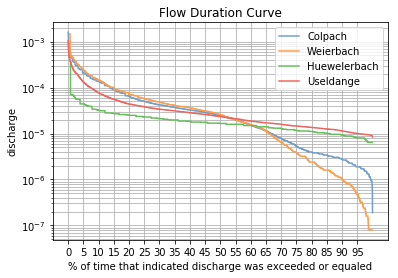

In [6]:
#specific discharge:
SpeQA=QA.resample('H').mean().copy() #hourly means
SpeQA*=(60.*60.) #convert m3/s to volume per hour

#get areas:
Area=pd.read_csv('catch_area.csv')

#apply conversion to specific discharge
SpeQA.Colpach/=Area.Colpach.values
SpeQA.Weierbach/=Area.Weierbach.values
SpeQA.Useldange/=Area.Useldange.values
SpeQA.Huewelerbach/=Area.Huewelerbach.values


fdc(SpeQA)

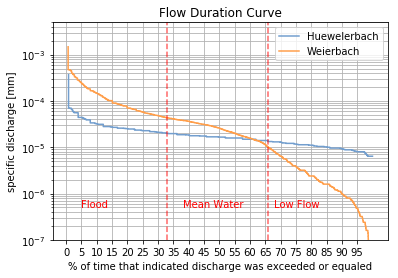

In [7]:
fdc(SpeQA[['Huewelerbach','Weierbach']])
ylabel('specific discharge [mm]')
#add quantile lines
plt.plot([33,33],[1e-7,5e-3],'r--',alpha=0.6)
plt.plot([66,66],[1e-7,5e-3],'r--',alpha=0.6)
plt.text(5,5e-7,'Flood',color='red')
plt.text(38,5e-7,'Mean Water',color='red')
plt.text(68,5e-7,'Low Flow',color='red')
ylim([1e-7,5e-3])
#savefig('fdc_annotated.pdf',bbox_tight=True)

Now that we have the FDCs let us interpret them. For this we may separate the FDC into 33% sections of flood, mean water and low flow along the x axis.

In general the Huewelerbach has a very narrow range of observed discharge. Extremes are rare and of low deviance from the observed means. The low flows are higher compared to the Weierbach, while mean water and floods are smaller. The Weierbach shows more variability and a large spread in all compartments. Extreme events at both ends are not too uncommon and more severe than in the Huewelerbach. The curve is showing several points of inflexion pointing to different flow regimes.


## Applications of the FDC

The Falkenmark water stress index is a measure of water stress (Falkenmark, 1989). It is defined as the fraction of the total annual runoff available for human use and proposes that scarcity is to be assumed below 1000 m3 water per year and capita.

Although a little theoretical, please calculate the probability that the required mean flow of the water scarcity line is undercut for a village with 300 inhabitants in both basins.

In [8]:
#annual precip weierbach
0.82*450000

369000.0

In [9]:
#how many capita could be supplied in the basin referenced to the falkenmark index
(QA*15*60).sum(axis=0)/3000

Colpach          8899.167600
Weierbach         217.264844
Huewelerbach      475.167485
Useldange       87623.888100
dtype: float64

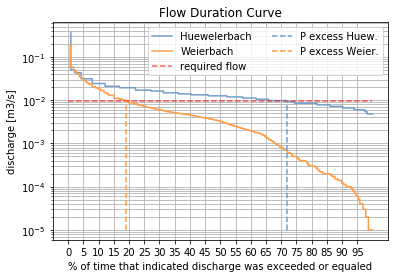

In [10]:
#We plot the FDC of the volumetric discharge
fdc(QA[['Huewelerbach','Weierbach']])
ylabel('discharge [m3/s]')

#We add the reference line for the requirement of 1000 m3 water for 300 inhabitants per year converted to m3/s
plt.plot([0,100],[(300*1000)/(365*24*60*60),(300*1000)/(365*24*60*60)],'r--',alpha=0.6,label='required flow')

#Now we can directly read the probability this value is excessed. 
#The reverse (1-P) gives the probability this value is undercut
from palettable.tableau import TableauMedium_10 as colorx
plt.plot([72,72],[1e-5,(300*1000)/(365*24*60*60)],'--',color=colorx.mpl_colors[0],label='P excess Huew.')
plt.plot([19,19],[1e-5,(300*1000)/(365*24*60*60)],'--',color=colorx.mpl_colors[1],label='P excess Weier.')
legend(ncol=2)
#savefig('fdc_q_annotate.pdf')

The result is:

 * at the Huewelerbach outlet, the village has a probability of water shortage of 28%
 * at the Weierbach outlet, the village faces water shortage with a probability of 81%

## Events and Runoff Concentration

We evaluate one storm event with regard to runoff concentration and runoff coefficient in different subbasins.



In [11]:
#get meteo data
#read file:
meteo = pd.read_csv('Meteo.csv')
#define time stamp as index
meteo.index=pd.to_datetime(meteo.iloc[:,0].values)
#drop old time stamp column
meteo=meteo.drop('Tag_Stunde',axis=1)

#get areas:
Area=pd.read_csv('catch_area.csv')

In [13]:
#use seaborn package for nicer plotting
import seaborn as sns
sns.set(style='whitegrid', palette='deep')

The excercise is based on a graphical solution. As such, we will generate a annotated plot to solve it.

Text(0.5,0,'Hour of day')

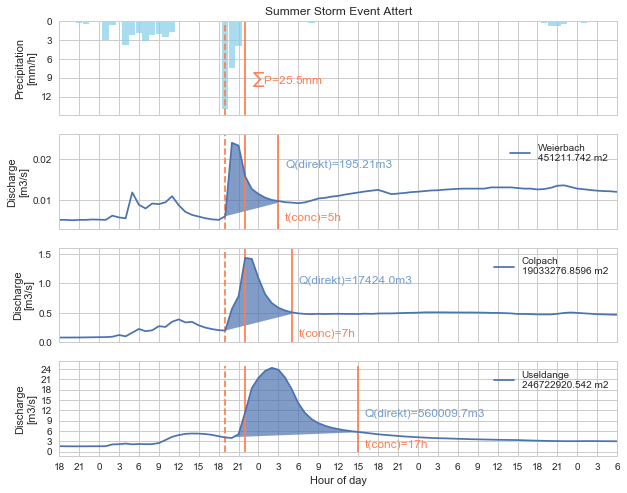

In [15]:
figsize(10,8)
tstart=pd.to_datetime('2013-06-19 18:00:00')
tstop=pd.to_datetime('2013-06-23 06:00:00')

dummy_P=meteo[tstart:tstop].SUM_NN050R.resample('H').sum()
dummy_T=meteo[tstart:tstop].AVG_TA200U.resample('H').mean()
dummy_Q=QA[tstart:tstop].Weierbach.resample('H').mean()
dummy_Q1=QA[tstart:tstop].Colpach.resample('H').mean()
dummy_Q2=QA[tstart:tstop].Useldange.resample('H').mean()

subplot(411)
bar(dummy_P.index,-dummy_P.values,color='skyblue',alpha=0.7,width=0.04)
vlines(dummy_Q.index[np.argmax(dummy_Q.values)]-pd.Timedelta(60*60, unit='s'),-15,0.,color='coral',linestyles='dashed')
vlines(dummy_Q.index[np.argmax(dummy_Q.values)]+pd.Timedelta(2*60*60, unit='s'),-15.,0.,color='coral')
text(dummy_Q.index[np.argmax(dummy_Q.values)]+pd.Timedelta(3*60*60, unit='s'),-10.,''.join(['$\sum$P=',str(dummy_P[dummy_Q.index[np.argmax(dummy_Q.values)]-pd.Timedelta(60*60, unit='s'):dummy_Q.index[np.argmax(dummy_Q.values)]+pd.Timedelta(3*60*60, unit='s')].sum()),'mm']),color='coral')
#plot(dummy_P.index,np.cumsum(-dummy_P.values),color='skyblue')
ylim(-15,0)
yticks(-np.arange(15)[::3],np.arange(15)[::3])
xticks(dummy_Q.resample('3H').mean().index,[])
xlim(tstart,tstop)
ylabel('Precipitation\n[mm/h]')
title('Summer Storm Event Attert')
#twinx()
#plot(dummy_T.index,dummy_T.values,color='coral')
#plot(dummy_T.index[[0,-1]],[0,0],':',color='black')
#ylim(-20,30)

subplot(412)
plot(dummy_Q.index,dummy_Q.values,label=''.join(['Weierbach\n'+str(Area.Weierbach[0])+' m2']))
d0=dummy_Q[dummy_Q.index[np.argmax(dummy_Q.values)]-pd.Timedelta(60*60, unit='s'):dummy_Q.index[np.argmax(dummy_Q.values)]+pd.Timedelta(7*60*60, unit='s')]
fill_between(d0.index,d0.values,np.arange(len(d0))/len(d0)*(d0.iloc[-1]-d0.iloc[0])+d0.iloc[0],alpha=0.7)
qd0=np.sum((d0.values-(np.arange(len(d0))/len(d0)*(d0.iloc[-1]-d0.iloc[0])+d0.iloc[0]))*3600.)
text(d0.index[-1]+pd.Timedelta(60*60, unit='s'),0.018,''.join(['Q(direkt)=',str(np.round(qd0,2)),'m3']),color=colorx.mpl_colors[0])
vlines(dummy_Q.index[np.argmax(dummy_Q.values)]-pd.Timedelta(60*60, unit='s'),0.003,0.026,color='coral',linestyles='dashed')
vlines(dummy_Q.index[np.argmax(dummy_Q.values)]+pd.Timedelta(2*60*60, unit='s'),0.003,0.026,color='coral')
vlines(dummy_Q.index[np.argmax(dummy_Q.values)]+pd.Timedelta(7*60*60, unit='s'),0.003,0.026,color='coral')
text(dummy_Q.index[np.argmax(dummy_Q.values)]+pd.Timedelta(8*60*60, unit='s'),0.005,'t(conc)=5h',color='coral')
ylim(0.003,0.026)
legend()
#ylim(0,25)
#yticks(np.arange(25)[::3])
xticks(dummy_Q.resample('3H').mean().index,[])
xlim(tstart,tstop)
ylabel('Discharge\n[m3/s]')

subplot(413)
plot(dummy_Q1.index,dummy_Q1.values,label=''.join(['Colpach\n'+str(Area.Colpach[0])+' m2']))
d1=dummy_Q1[dummy_Q.index[np.argmax(dummy_Q.values)]-pd.Timedelta(60*60, unit='s'):dummy_Q.index[np.argmax(dummy_Q.values)]+pd.Timedelta(9*60*60, unit='s')]
fill_between(d1.index,d1.values,np.arange(len(d1))/len(d1)*(d1.iloc[-1]-d1.iloc[0])+d1.iloc[0],alpha=0.7)
qd1=np.sum((d1.values-(np.arange(len(d1))/len(d1)*(d1.iloc[-1]-d1.iloc[0])+d1.iloc[0]))*3600.)
text(d1.index[-1]+pd.Timedelta(60*60, unit='s'),1.,''.join(['Q(direkt)=',str(np.round(qd1,2)),'m3']),color=colorx.mpl_colors[0])
vlines(dummy_Q.index[np.argmax(dummy_Q.values)]-pd.Timedelta(60*60, unit='s'),0.003,1.6,color='coral',linestyles='dashed')
vlines(dummy_Q.index[np.argmax(dummy_Q.values)]+pd.Timedelta(2*60*60, unit='s'),0.003,1.6,color='coral')
vlines(dummy_Q.index[np.argmax(dummy_Q.values)]+pd.Timedelta(9*60*60, unit='s'),0.003,1.6,color='coral')
text(dummy_Q.index[np.argmax(dummy_Q.values)]+pd.Timedelta(10*60*60, unit='s'),0.1,'t(conc)=7h',color='coral')
ylim(0.003,1.6)
legend()
xticks(dummy_Q1.resample('3H').mean().index,[])
xlim(tstart,tstop)
ylabel('Discharge\n[m3/s]')

subplot(414)
plot(dummy_Q2.index,dummy_Q2.values,label=''.join(['Useldange\n'+str(Area.Useldange[0])+' m2']))
d2=dummy_Q2[dummy_Q.index[np.argmax(dummy_Q.values)]-pd.Timedelta(60*60, unit='s'):dummy_Q.index[np.argmax(dummy_Q.values)]+pd.Timedelta(19*60*60, unit='s')]
fill_between(d2.index,d2.values,np.arange(len(d2))/len(d2)*(d2.iloc[-1]-d2.iloc[0])+d2.iloc[0],alpha=0.7)
qd2=np.sum((d2.values-(np.arange(len(d2))/len(d2)*(d2.iloc[-1]-d2.iloc[0])+d2.iloc[0]))*3600.)
text(d2.index[-1]+pd.Timedelta(60*60, unit='s'),10,''.join(['Q(direkt)=',str(np.round(qd2,2)),'m3']),color=colorx.mpl_colors[0])
vlines(dummy_Q.index[np.argmax(dummy_Q.values)]-pd.Timedelta(60*60, unit='s'),0.003,25.,color='coral',linestyles='dashed')
vlines(dummy_Q.index[np.argmax(dummy_Q.values)]+pd.Timedelta(2*60*60, unit='s'),0.003,25.,color='coral')
vlines(dummy_Q.index[np.argmax(dummy_Q.values)]+pd.Timedelta(19*60*60, unit='s'),0.003,25.,color='coral')
text(dummy_Q.index[np.argmax(dummy_Q.values)]+pd.Timedelta(20*60*60, unit='s'),1,'t(conc)=17h',color='coral')
legend()
#ylim(0,25)
yticks(np.arange(25)[::3])
xticks(dummy_Q2.resample('3H').mean().index,dummy_Q2.resample('3H').mean().index.hour)
xlim(tstart,tstop)
ylabel('Discharge\n[m3/s]')

xlabel('Hour of day')
#savefig('attert_summer_storm_annot.pdf')

A summer storm event was recorded at several gauges in the Attert basin. Calculate the following parameters for the three gauges:

 * Concentration time of discharge
 * Runoff coefficient of direct event runoff
 
Compare and interpret your results.

In [16]:
#calculate the runoff coefficients (RC)

In [17]:
Psum = dummy_P[dummy_Q.index[np.argmax(dummy_Q.values)]-pd.Timedelta(60*60, unit='s'):dummy_Q.index[np.argmax(dummy_Q.values)]+pd.Timedelta(2*60*60, unit='s')].sum()/1000. #sum of precipitation in m

RC=np.array([(qd0/Area.Weierbach)/Psum,
          (qd1/Area.Colpach)/Psum,
          (qd2/Area.Useldange)/Psum])

print('Runoff Coefficients:')
pd.DataFrame(RC,index=['Weierbach','Colpach','Useldange'])

Runoff Coefficients:


,0
Weierbach,0.017033
Colpach,0.036041
Useldange,0.089362


In [18]:
#another event (snow melt) for comparison

Text(0.5,0,'Hour of day')

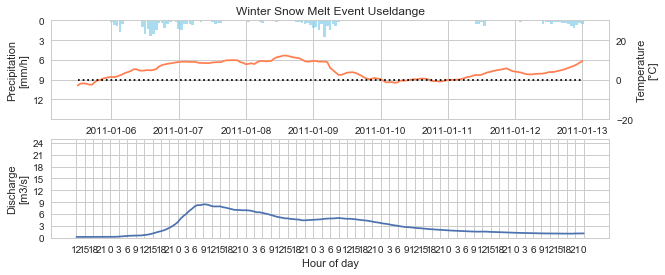

In [20]:
figsize(10,4)
tstart=pd.to_datetime('2011-01-05 12:00:00')
tstop=pd.to_datetime('2011-01-13 00:00:00')

dummy_P=meteo[tstart:tstop].SUM_NN050R.resample('H').sum()
dummy_T=meteo[tstart:tstop].AVG_TA200R.resample('H').mean()
dummy_Q=QA[tstart:tstop].Colpach.resample('H').mean()

subplot(211)
bar(dummy_P.index,-dummy_P.values,color='skyblue',alpha=0.7,width=0.04)
#plot(dummy_P.index,np.cumsum(-dummy_P.values),color='skyblue')
ylim(-15,0)
yticks(-np.arange(15)[::3],np.arange(15)[::3])
xticks(dummy_Q.resample('3H').mean().index,dummy_Q.resample('3H').mean().index.hour)
ylabel('Precipitation\n[mm/h]')
title('Winter Snow Melt Event Useldange')

twinx()
plot(dummy_T.index,dummy_T.values,color='coral')
plot(dummy_T.index[[0,-1]],[0,0],':',color='black')
ylim(-20,30)
ylabel('Temperature\n[°C]')

subplot(212)
plot(dummy_Q.index,dummy_Q.values)
ylim(0,25)
yticks(np.arange(25)[::3])
xticks(dummy_Q.resample('3H').mean().index,dummy_Q.resample('3H').mean().index.hour)
ylabel('Discharge\n[m3/s]')
xlabel('Hour of day')